In [204]:
import os
from pathlib import Path
from typing import Callable

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from segregation.aspatial import MinMax
import rasterio as rio
from scipy.spatial.distance import cdist


data_dir = Path('../data')

In [205]:
def get_xy(
        geodf: gpd.GeoDataFrame,
        geometry_col: str = None,
) -> gpd.GeoDataFrame:

    if not geometry_col:
        geometry_col = geodf.geometry.name

    if geodf[geometry_col].geom_type[0] == 'Point':
        geodf['x'] = geodf[geometry_col].apply(lambda geom: geom.x)
        geodf['y'] = geodf[geometry_col].apply(lambda geom: geom.y)
    else:
        geodf['x'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[0]))
        geodf['y'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[1]))
    return geodf


def kernel_density_surface(
        data: gpd.GeoDataFrame,
        group: str,
        bandwidth,
        cell_size,
        kernel_function: Callable,
):
    pop = get_xy(data)
    pad = bandwidth * 2

    minx, miny, maxx, maxy = pop.geometry.total_bounds

    minx -= pad
    miny -= pad
    maxx += pad
    maxy += pad

    x = np.arange(minx, maxx, cell_size)
    y = np.arange(miny, maxy, cell_size)

    X, Y = np.meshgrid(x, y)

    xy = np.vstack([Y.ravel(), X.ravel()]).T

    U = cdist(xy, pop[['y', 'x']].values, metric='euclidean')
    W = kernel_function(U, bandwidth=bandwidth)

    density = (W * pop[group].values).sum(axis=1).reshape(X.shape)

    geotiff_meta = {
        'driver': 'GTiff',
        'count': 1,
        'dtype': 'float64',
        'width': len(x),
        'height': len(y),
        'crs': data.crs,
        'transform': rio.transform.from_bounds(
            west=minx,
            east=maxx,
            north=maxy,
            south=miny,
            width=len(x),
            height=len(y),
        )
    }

    return density[::-1, ], geotiff_meta


def get_S(
        data,
        bandwidth,
        cell_size,
        kernel_function,
):
    if data.empty:
        return None

    density_total, _ = kernel_density_surface(
        data,
        group='total',
        bandwidth=bandwidth,
        cell_size=cell_size,
        kernel_function=kernel_function,
    )
    density_orthodox, _ = kernel_density_surface(
        data,
        group='orthodox',
        bandwidth=bandwidth,
        cell_size=cell_size,
        kernel_function=kernel_function,
    )

    density = pd.DataFrame({
            'orthodox': density_orthodox.flatten(),
            'total': density_total.flatten(),
         })
    S = MinMax(density, 'orthodox', 'total')

    return S


In [206]:
def aggregate_sum(
        data: pd.DataFrame,
        group_cols,
        target_cols,
) -> pd.DataFrame:
    data.sort_values(by=target_cols, inplace=True)
    agg_data = pd.DataFrame(columns=data.columns)

    if isinstance(data, gpd.GeoDataFrame):
        agg_data.crs = data.crs

    last = pd.Series()
    len_targets = len(target_cols)
    sums = pd.Series(np.zeros(len_targets), index=target_cols)
    for _, row in data.iterrows():
        if row[group_cols].all() != last.all():
            last = row[group_cols]
            new_row = row
            new_row[target_cols] = sums
            sums = pd.Series(np.zeros(len_targets), index=target_cols)
            agg_data = agg_data.append(new_row)
        else:
            sums += row[target_cols]

    return agg_data.reindex()


def prepare_pop_data(
        population_data: pd.DataFrame,
        num_cols=None,
) -> pd.DataFrame:

    pop_frame = population_data.fillna(value=0)

    if not num_cols:
        num_cols = [
            'total_men',
            'total_women',
            'orthodox',
            'other_christian',
            'other_religion',
        ]

    pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)

    pop_frame['lutheran'] = pop_frame['total_men total_women'.split()].sum(axis=1) \
                            - pop_frame['other_christian orthodox other_religion'.split()].sum(axis=1)

    pop_frame['total'] = pop_frame['other_christian orthodox other_religion lutheran'.split()].sum(axis=1)

    pop_frame = aggregate_sum(
        pop_frame,
        group_cols='district plot_number'.split(),
        target_cols=[
            'total_men',
            'total_women',
            'orthodox',
            'other_christian',
            'other_religion',
        ],
    )

    return pop_frame

In [207]:
def split_plots(
        geodataframe: gpd.GeoDataFrame,
        target_col: str,
        separator: str = ',',
) -> gpd.GeoDataFrame:

    new_geodataframe = gpd.GeoDataFrame(columns=geodataframe.columns)

    for _, row in geodataframe.iterrows():
        plots = str(row[target_col]).split(separator)

        if len(plots) < 2:
            new_geodataframe = new_geodataframe.append(row)
            continue

        for plot in plots:
            new_row = row
            new_row[target_col] = plot
            new_geodataframe = new_geodataframe.append(new_row)

    assert len(new_geodataframe.index) == len(list(pd.core.common.flatten(
        [
            str(w).split(separator)
            for w
            in geodataframe[target_col]
        ]))), 'splitting failed'

    return new_geodataframe.reindex()


In [208]:
def interval_sample(
        iterable,
        length,
) -> list:
    ratio = len(iterable) / length
    sample = []

    last_int = None

    for i, n in enumerate(iterable):
        integer = i // ratio

        if integer != last_int:
            last_int = integer
            sample.append(n)

    assert len(sample) == length

    return sample


def get_aggregate_locations(
        *,
        population_data: pd.DataFrame,
        location_data: gpd.GeoDataFrame,
) -> gpd.GeoDataFrame:

    geodata_by_district = []

    for dist in population_data['district'].unique():
        pop = population_data[population_data.district == dist]
        loc = location_data[location_data.district == dist]

        pop = pop.reset_index()
        loc = loc.reset_index()

        district = _get_aggregate_locations_by_district(pop, loc)
        geodata_by_district.append(district)

    geodata = pd.concat(geodata_by_district, ignore_index=True)
    geodata.crs = location_data.crs

    return geodata


def _get_aggregate_locations_by_district(
        population_data: pd.DataFrame,
        location_data: gpd.GeoDataFrame,
) -> gpd.GeoDataFrame:

    len_pop = len(population_data.index)
    len_loc = len(location_data.index)

    if len_loc == 0 or len_pop == 0:
        return gpd.GeoDataFrame()

    elif len_loc < len_pop:
        sample_index = interval_sample(
            population_data.index,
            len_loc,
        )
        new_geom = gpd.GeoDataFrame(
            {'geometry': location_data.geometry},
            index=sample_index,
        )

        try:
            new_geom = new_geom.align(
                population_data,
                join='outer',
                method='pad',
            )
        except NotImplementedError:
            return gpd.GeoDataFrame()

        location_data = new_geom

    elif len_pop < len_loc:
        sample_index = interval_sample(
            location_data.index,
            len_pop,
        )
        location_data = location_data.loc[sample_index, ]

    location_data = location_data.reset_index()
    location_data = location_data.drop(columns=['level_0',  'index'])
    population_data = population_data.drop(columns=['page_number', 'district'])

    geodata = pd.concat(
        [location_data, population_data],
        axis=1,
    )
    geodata = geodata.drop(columns=[
        'index',
        'Unnamed: 0',
    ])

    return geodata


In [209]:
def quartic_kernel(u, bandwidth):
    return np.where(
            np.abs(u) <= bandwidth,
            3 / (np.pi * bandwidth * bandwidth) * (1 - (u / bandwidth) ** 2) ** 2,
            0
    )

           100       150       200       250       300       400       500
1880  0.608815  0.546627  0.504868  0.478455  0.460749  0.438036  0.420042
1885  0.671597  0.606566  0.566940  0.540537  0.516593  0.470903  0.430060
1890  0.581716  0.498366  0.450918  0.421090  0.396483  0.354530  0.323991
1895  0.515813  0.448855  0.405911  0.375842  0.353361  0.323189  0.304732
1900  0.540087  0.462334  0.410172  0.376845  0.352996  0.324988  0.306599
1905  0.544618  0.453529  0.398580  0.359421  0.332018  0.295998  0.271061
1910  0.578004  0.478687  0.407709  0.355316  0.316307  0.266649  0.231639
1915  0.590120  0.518592  0.475702  0.452372  0.438666  0.419111  0.400979


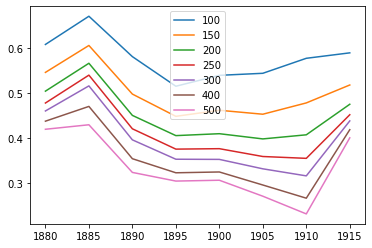

In [210]:
district_codes = pd.read_csv(data_dir / 'district_codes.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}

location_data = gpd.read_file(data_dir / 'intermediary' / 'plots_points_1878.shp')
location_data = split_plots(location_data, target_col='NUMBER')
location_data['district'] = [district_codes[int(d)] for d in location_data['DISTRICT']]
location_data['plot_number'] = [str(i) for i in location_data['NUMBER']]

results = {}
bws = 100, 150, 200, 250, 300, 400, 500

for year in range(1880, 1916, 5):
    s_ = []

    for bw in bws:

        population_data = pd.read_csv(data_dir / 'intermediary' / f'pop_by_page_{year}.csv').pipe(prepare_pop_data)

        population_data = population_data[population_data.district != 'Pietarin_esikaupunki']
        data = get_aggregate_locations(
            population_data=population_data,
            location_data=location_data,
        )

        S = get_S(
            data=data,
            bandwidth=bw,
            cell_size=25,
            kernel_function=quartic_kernel,
        )

        s_.append(S.statistic)

    results[year] = s_

results = pd.DataFrame.from_dict(
    results,
    orient='index',
    columns=bws,
)
print(results)
results.plot()


# Results

Decrease until Russification
